<a href="https://colab.research.google.com/github/dr-song-summer-project/AI/blob/main/Clustering/K_Means_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**https://techblog-history-younghunjo1.tistory.com/114**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
clustering_num = 24
similarity_cmp = 'reviewRate'

In [ ]:
# 학습용 데이터셋 불러오기
import pandas as pd
document_df = pd.read_excel('/content/drive/My Drive/닥터송 여름 프로젝트/4. 대-스타 해결 2/DRSONG_AI_Project/AI/전처리/data/unlabeled_data_prepro_keyword.xlsx')
# document_df.head()

document_df.drop(['Unnamed: 0', 'encodedSenderId', 'encodedTargetId', 'DateTime'], axis=1, inplace=True)
document_df.head()

,reviewIndex,reviewContent,reviewRate,reviewType
0,0,시간 곧 다 일 불만족 신 부분 나름 조율 다른 조건 조율 과정 없이 바로 워킹맘 ...,1,recruitReview
1,1,자신감 아기 거 좋다 것 같다 파이팅,3,recruitReview
2,2,아이 의의 산 표현 확실하다 아이 터 좋아하다 어머님께 아쉽다,3,recruitReview
3,3,사정 있다 아쉽다 함께,3,recruitReview
4,4,전화 인터뷰 때 저희 집 오신 첫날 정기 좋다 사 전 말 이사 곳도 수 있다 이 동...,1,recruitReview


In [ ]:
# 텍스트 단어들의 어근 원형을 추출하기 위해 함수 생성
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import WordNetLemmatizer
import nltk
import string
nltk.download('punkt')
nltk.download('wordnet')
# string.puncutaion에 문자열의 모든 구두점이 들어있음
# 이를 활용해서 Tokenize시킬 때 구두점들을 제외하기 위한 것
# ord('문자열') => 문자열의 ASCII코드를 반환해줌!
# dict(key, value)형태로 모든 구두점의 각 ASCII코드를 key값으로 넣어주자!
remove_punct_dict = dict((ord(punct), None) for punct in string.punctuation)
lemmar = WordNetLemmatizer()

# 토큰화한 각 단어들의 원형들을 리스트로 담아서 반환
def LemTokens(tokens):
    return [lemmar.lemmatize(token) for token in tokens]
# 텍스트를 Input으로 넣어서 토큰화시키고 토큰화된 단어들의 원형들을 리스트로 담아 반환
def LemNormalize(text):
    # .translate인자에 구두점 dict넣어주어서 구두점 삭제해준 상태로 토큰화시키기!
    return LemTokens(nltk.word_tokenize(text.lower().translate(remove_punct_dict)))

# Tf-idf 벡터화시키면서 cusotmized해준 토큰화+어근추출 방식 tokenizer인자에 넣어주기
# 벡터화시킬 Tf-idf 도구 옵션 추가해서 구축
# 1,2gram적용, 빈도수 0.05이하, 0.85이상의 빈도수 단어들 제거
tfidf_vect = TfidfVectorizer(tokenizer=LemNormalize,
                            stop_words='english', ngram_range=(1,2),
                            min_df=0.05, max_df=0.85)
# fit_transform으로 위에서 구축한 도구로 텍스트 벡터화
# ftr_vect = tfidf_vect.fit_transform(document_df['reviewContent'])
ftr_vect = tfidf_vect.fit_transform(document_df['reviewContent'].values.astype('U'))
print(ftr_vect.shape)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


(13283, 39)


In [ ]:
# K-means로 clustering_num개 군집으로 문서 군집화시키기
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=clustering_num, max_iter=10000, random_state=42)
# 비지도 학습이니 feature로만 학습시키고 예측
cluster_label = kmeans.fit_predict(ftr_vect)

print(cluster_label)

# 군집화한 레이블값들을 document_df 에 추가하기
document_df['cluster_label'] = cluster_label
print(document_df.sort_values(by=['cluster_label']))
# document_df['reviewType'] = document_df['reviewType'].replace(['recruitReview', 'interviewReview', 'failureReview'],[0, 1, 2])

[14 17 23 ... 11 17 13]
      reviewIndex  ... cluster_label
1539         1539  ...             0
1849         1849  ...             0
7901         7901  ...             0
5093         5093  ...             0
7904         7904  ...             0
...           ...  ...           ...
661           661  ...            23
2522         2522  ...            23
1351         1351  ...            23
680           680  ...            23
927           927  ...            23

[13283 rows x 5 columns]


In [ ]:
document_df.to_excel('clustering_result.xlsx', header=True, index=False)

Text(0.5, 1.0, 'clustering result')

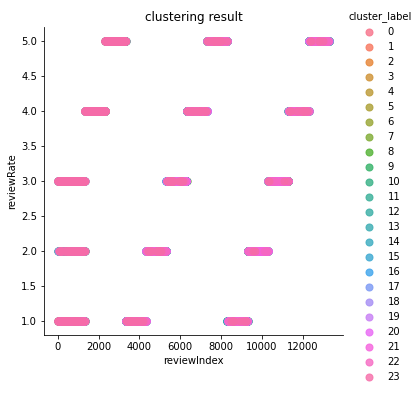

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

sb.lmplot(x='reviewIndex', y='reviewRate', data=document_df, height=5, fit_reg=False, scatter_kws={"s":50}, hue = 'cluster_label')

plt.title('clustering result')

In [ ]:
def get_cluster_details(cluster_model, cluster_data, feature_names,
                       cluster_num, top_n_features=10):
    cluster_details = {}
    # 각 클러스터 레이블별 feature들의 center값들 내림차순으로 정렬 후의 인덱스를 반환
    center_feature_idx = cluster_model.cluster_centers_.argsort()[:,::-1]
    
    # 개별 클러스터 레이블별로 
    for cluster_num in range(cluster_num):
        # 개별 클러스터별 정보를 담을 empty dict할당
        cluster_details[cluster_num] = {}
        cluster_details[cluster_num]['cluster'] = cluster_num
        
        # 각 feature별 center값들 정렬한 인덱스 중 상위 10개만 추출
        top_ftr_idx = center_feature_idx[cluster_num, :top_n_features]
        top_ftr = [feature_names[idx] for idx in top_ftr_idx]
        # top_ftr_idx를 활용해서 상위 10개 feature들의 center값들 반환
        # 반환하게 되면 array이기 떄문에 리스트로바꾸기
        top_ftr_val = cluster_model.cluster_centers_[cluster_num, top_ftr_idx].tolist()
        
        # cluster_details 딕셔너리에다가 개별 군집 정보 넣어주기
        cluster_details[cluster_num]['top_features'] = top_ftr
        cluster_details[cluster_num]['top_featrues_value'] = top_ftr_val
        # 해당 cluster_num으로 분류된 파일명(문서들) 넣어주기
        filenames = cluster_data[cluster_data['cluster_label']==cluster_num][similarity_cmp]
        # filenames가 df으로 반환되기 떄문에 값들만 출력해서 array->list로 변환
        filenames = filenames.values.tolist()
        cluster_details[cluster_num]['filenames'] = filenames
    
    return cluster_details

def print_cluster_details(cluster_details):
    for cluster_num, cluster_detail in cluster_details.items():
        print(f"#####Cluster Num: {cluster_num}")
        print()
        print("상위 10개 feature단어들:\n", cluster_detail['top_features'])
        print()
        print(f"Cluster {cluster_num}으로 분류된 문서들:\n{cluster_detail['filenames'][:10]}")
        print('-'*20)

feature_names = tfidf_vect.get_feature_names()
cluster_details = get_cluster_details(cluster_model=kmeans,
                                     cluster_data=document_df,
                                     feature_names=feature_names,
                                     cluster_num=clustering_num,
                                     top_n_features=5)
print_cluster_details(cluster_details)

In [ ]:
# 클러스터링된 문서들 중에서 특정 문서를 하나 선택한 후 비슷한 문서 추출
from sklearn.metrics.pairwise import cosine_similarity
random_int = 1
hotel_idx = document_df[document_df['cluster_label']==0].index
print("호텔 카테고리로 클러스터링된 문서들의 인덱스:\n",hotel_idx)
print("내용 : ", document_df[document_df['reviewIndex']==hotel_idx[random_int]].reviewContent)
# 호텔 카테고리로 클러스터링 된 문서들의 인덱스 중 하나 선택해 비교 기준으로 삼을 문서 선정
comparison_doc = document_df.iloc[hotel_idx[random_int]][similarity_cmp]
print("##유사도 비교 기준 문서 이름:",comparison_doc,'##')
print()

# 위에서 추출한 호텔 카테고리로 클러스터링된 문서들의 인덱스 중 0번인덱스(비교기준문서)제외한
# 다른 문서들과의 유사도 측정
similarity = cosine_similarity(ftr_vect[hotel_idx[random_int]], ftr_vect[hotel_idx])
# print(similarity)

호텔 카테고리로 클러스터링된 문서들의 인덱스:
 Int64Index([   20,    55,   114,   128,   177,   266,   288,   292,   302,
              504,
            ...
            13227, 13232, 13236, 13238, 13245, 13247, 13248, 13249, 13252,
            13267],
           dtype='int64', length=516)
내용 :  55    기간 거절 열한 번 계속 연락 처음 기간 다음 다른 분과 매칭 계속 계속 연락
Name: reviewContent, dtype: object
##유사도 비교 기준 문서 이름: 3 ##



In [ ]:
# 비교기준 문서와 다른 문서들간의 유사도 살펴보기
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
# array 내림차순으로 정렬한 후 인덱스 반환 [:,::-1] 모든행에 대해서 열을 내림차순으로!
sorted_idx = similarity.argsort()[:,::-1]
# 비교문서 당사자는 제외한 인덱스 추출
sorted_idx = sorted_idx[:, 1:]

# 유사도가 큰 순으로 hotel_idx(label=1인 즉, 호텔과관련된 내용의 문서이름들의 index들)에서 재 정렬 
# index로 넣으려면 1차원으로 reshape해주기!
hotel_sorted_idx = hotel_idx[sorted_idx.reshape(-1,)]
# 유사도 행렬값들을 유사도가 큰 순으로 재정렬(비교 문서 당사자는 제외)
hotel_sim_values = np.sort(similarity.reshape(-1,))[::-1]
hotel_sim_values = hotel_sim_values[1:]
# 이렇게 되면 비교문서와 가장 유사한 순으로 '해당문서의index-유사도값' 으로 동일한 위치가 매핑된 두 개의 array!
# 그래서 그대로 데이터프레임의 각 칼럼으로 넣어주기
print(hotel_sorted_idx)
print(hotel_sim_values)
print()
print("길이 비교", len(hotel_sorted_idx), len(hotel_sim_values))
print()
# 빈 데이터프레임 생성
hotel_sim_df = pd.DataFrame()
# hotel_sorted_idx 와 hotel_sim_values 매핑시킨 array임
hotel_sim_df[similarity_cmp] = document_df.iloc[hotel_sorted_idx][similarity_cmp]
hotel_sim_df['similarity'] = hotel_sim_values

plt.figure(figsize=(15,10))
sns.barplot(data=hotel_sim_df, x=similarity_cmp, y='similarity')
plt.title(comparison_doc)

# **정확도 측정 - F1 Score**

https://eunsukimme.github.io/ml/2019/10/21/Accuracy-Recall-Precision-F1-score/

In [ ]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

test_df = pd.read_csv('/content/drive/My Drive/닥터송 여름 프로젝트/4. 대-스타 해결 2/DRSONG_AI_Project/AI/전처리/data/test_data.csv')

test_df.drop(['encodedSenderId', 'encodedTargetId', 'DateTime'], axis=1, inplace=True)
# test_df.head()

labels = test_df['reviewRate'].values.tolist() #실제 측정값
print(labels)

[5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1]


In [ ]:
guesses = [0, 1, 1, 1, 1, 0, 1, 0, 1, 0]	# 예측된 결과

print(accuracy_score(labels, guesses))	# 0.3
print(recall_score(labels, guesses))	# 0.42
print(precision_score(labels, guesses))	# 0.5
print(f1_score(labels, guesses))	# 0.46